In [1]:
# %% Don't have to restart kernel and reimport each time you modify a dependency
%reload_ext autoreload
%autoreload 2

# %%
# Imports
from typing import List, Tuple, Dict, Union, Optional, Callable
import re 

import numpy as np
import pandas as pd
import torch as t
import plotly.express as px
import plotly as py
import plotly.graph_objects as go
from tqdm import tqdm
from einops import rearrange
from IPython.display import Video, display, clear_output
from ipywidgets import Text, interact, IntSlider, fixed, FloatSlider, Dropdown
import itertools
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip
import matplotlib.pyplot as plt

# NOTE: this is Monte's RL hooking code (and other stuff will be added in the future)
# Install normally with: pip install circrl
import circrl.module_hook as cmh
import procgen_tools.models as models
from experiments.patch_utils import *

# %% 
# Load two levels and get values
import pickle as pkl
from procgen import ProcgenGym3Env

rand_region = 5
# Check whether we're in jupyter
try:
    get_ipython()
    in_jupyter = True
except NameError:
    in_jupyter = False
path_prefix = '../' if in_jupyter else ''

# %%
# Load model

policy = models.load_policy(path_prefix + f'trained_models/maze_I/model_rand_region_{rand_region}.pth', 15,
    t.device('cpu'))

# %% Experiment parameters
label = 'embedder.block2.res1.resadd_out'
interesting_coeffs = np.linspace(-2/3,2/3,10) 
hook = cmh.ModuleHook(policy)

In [2]:
# Let's load a dummy observation with only one nonzero value
# This is the same as the one used in rollout-patch.py
dummy_obs = np.zeros((2, 3, 64, 64), dtype=np.float32)
dummy_obs[0, 0, 0, 0] = 1
hook.probe_with_input(dummy_obs, func=forward_func_policy)

# Now let's visualize the convolutions, at each layer
labels = list(hook.values_by_label.keys()) 
# Use regex to check whether the label contains 'conv' and 'out', with an optional number in between
conv_labels = [l for l in labels if re.match(r'.*conv.*out.*', l)]
print(conv_labels)

['embedder.block1.conv_out', 'embedder.block1.res1.conv1_out', 'embedder.block1.res1.conv2_out', 'embedder.block1.res2.conv1_out', 'embedder.block1.res2.conv2_out', 'embedder.block2.conv_out', 'embedder.block2.res1.conv1_out', 'embedder.block2.res1.conv2_out', 'embedder.block2.res2.conv1_out', 'embedder.block2.res2.conv2_out', 'embedder.block3.conv_out', 'embedder.block3.res1.conv1_out', 'embedder.block3.res1.conv2_out', 'embedder.block3.res2.conv1_out', 'embedder.block3.res2.conv2_out']


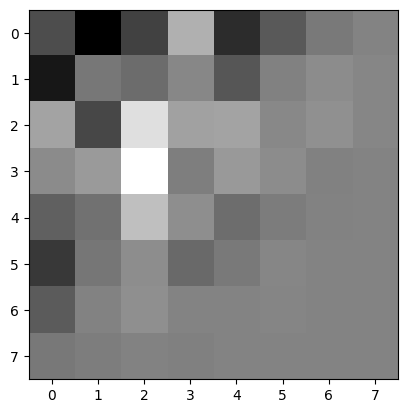

In [3]:
# Now that we have the conv labels, let's visualize the activations at each one
for label in conv_labels:
    activations = hook.get_value_by_label(label)
    plt.imshow(activations[0,0,:,:] - activations[1,0,:,:], cmap='gray')